<a href="https://colab.research.google.com/github/ScaratP/2025-Machine-Learning-HW/blob/main/2025MLex3_11111124%E7%8E%8B%E6%9B%B8%E5%A7%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Leaves Segmentation Challenge - 深度學習模型實作


1. 環境設置與函式庫載入

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

# 設置設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

使用設備: cpu


In [22]:
!unzip "A1.zip" -d A1

Archive:  A1.zip
replace A1/A1/plant001_label.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

2. 資料集載入與分析

In [23]:
import os

extract_path='A1/A1'
# 獲取所有圖檔
all_files = [f for f in os.listdir(extract_path) if f.endswith(('.png', '.jpg'))]

# 依據檔名分類：影像 vs 遮罩
image_files = sorted([f for f in all_files if '_rgb' in f.lower()])
mask_files = sorted([f for f in all_files if '_label' in f.lower()])

# 建立配對：以 plantXXX 為 key
image_dict = {f.split('_')[0]: f for f in image_files}
mask_dict = {f.split('_')[0]: f for f in mask_files}

# 保留有完整配對的樣本
paired_keys = sorted(set(image_dict.keys()) & set(mask_dict.keys()))
paired_files = [(image_dict[k], mask_dict[k]) for k in paired_keys]

# 檢查結果
print("資料集結構分析：")
print(f"總圖片數量: {len(all_files)}")
print(f"影像檔案數量 (_rgb): {len(image_files)}")
print(f"遮罩檔案數量 (_label): {len(mask_files)}")

print(f"\n前5個影像檔案: {image_files[:5]}")
print(f"前5個遮罩檔案: {mask_files[:5]}")


資料集結構分析：
總圖片數量: 256
影像檔案數量 (_rgb): 128
遮罩檔案數量 (_label): 128

前5個影像檔案: ['plant001_rgb.png', 'plant002_rgb.png', 'plant005_rgb.png', 'plant006_rgb.png', 'plant007_rgb.png']
前5個遮罩檔案: ['plant001_label.png', 'plant002_label.png', 'plant005_label.png', 'plant006_label.png', 'plant007_label.png']


影像尺寸: (530, 500, 3)


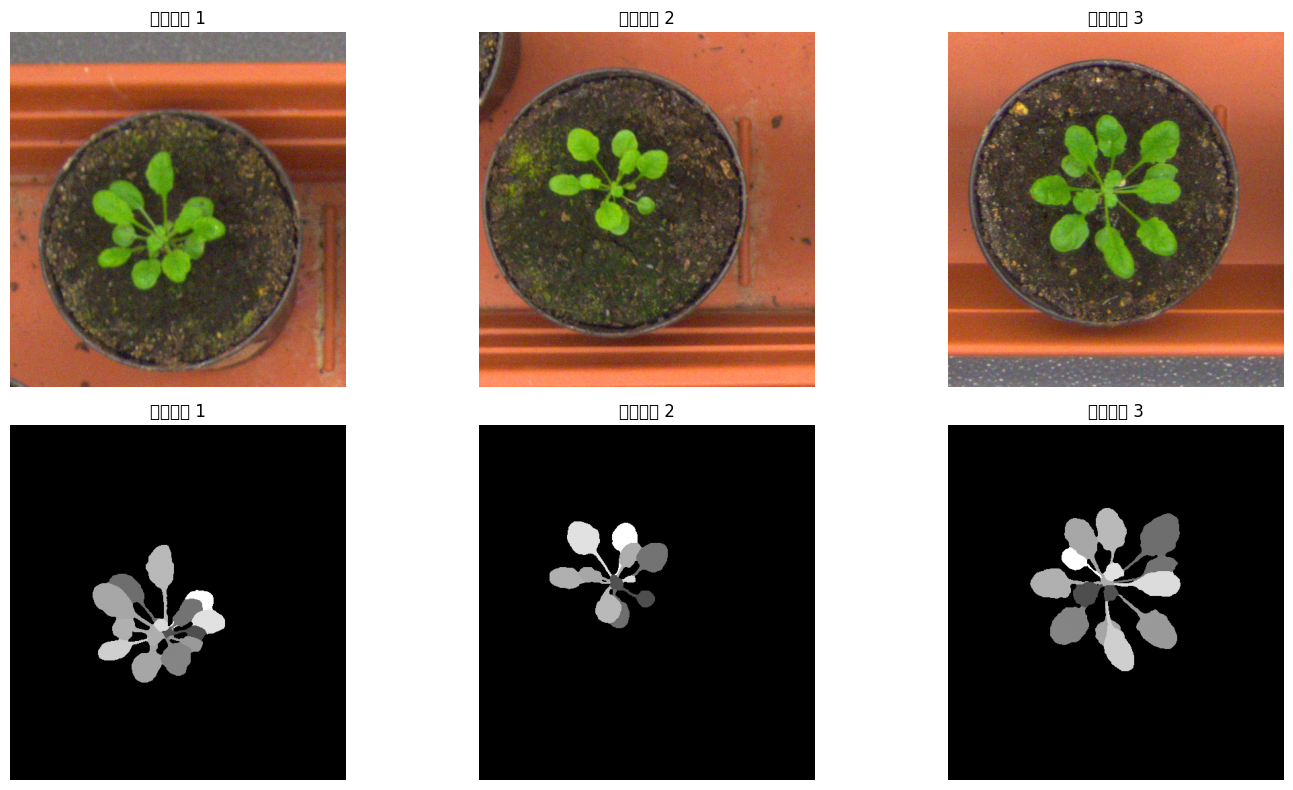

In [24]:
# 分析影像尺寸（使用配對資料）
sample_img_path = os.path.join(extract_path, paired_files[0][0])
sample_img = cv2.imread(sample_img_path)
print(f"影像尺寸: {sample_img.shape}")

# 修正版資料視覺化函數
def visualize_samples(num_samples=3):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))

    for i in range(num_samples):
        img_file, mask_file = paired_files[i]
        img_path = os.path.join(extract_path, img_file)
        mask_path = os.path.join(extract_path, mask_file)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 顯示原始影像
        axes[0, i].imshow(image)
        axes[0, i].set_title(f'原始影像 {i+1}')
        axes[0, i].axis('off')

        # 顯示遮罩
        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].set_title(f'分割遮罩 {i+1}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# 執行視覺化
visualize_samples()


3. 資料集類別定義

In [25]:
class LeafDataset(Dataset):
    def __init__(self, image_files, mask_files, images_dir, masks_dir, transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 載入影像
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = cv2.imread(img_path)

        # 錯誤處理：檢查影像是否成功載入
        if image is None:
            raise ValueError(f"無法載入影像: {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 載入遮罩
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 錯誤處理：檢查遮罩是否成功載入
        if mask is None:
            raise ValueError(f"無法載入遮罩: {mask_path}")

        # 正規化遮罩值到0-1，並確保是 float32 類型
        mask = (mask / 255.0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # 確保遮罩是 float 類型並添加 channel 維度
        return image, mask.unsqueeze(0).float()

4. U-Net 模型架構定義

In [26]:
class DoubleConv(nn.Module):
    """雙重卷積層 (conv -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder (下採樣路徑)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(64, 128)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(128, 256)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(256, 512)
        )
        self.down4 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(512, 1024)
        )

        # Decoder (上採樣路徑)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        # 輸出層
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder with skip connections
        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)

        output = self.outc(x)
        return torch.sigmoid(output)

# 模型初始化
model = UNet(n_channels=3, n_classes=1).to(device)
print(f"模型參數數量: {sum(p.numel() for p in model.parameters())}")

模型參數數量: 31043521


5. 損失函數與評估指標

In [27]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = pred.contiguous()
        target = target.contiguous()

        intersection = (pred * target).sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + self.smooth)

        return 1 - dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return self.alpha * bce_loss + (1 - self.alpha) * dice_loss

def dice_coefficient(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    target = (target > threshold).float()

    intersection = (pred * target).sum()
    dice = (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

    return dice.item()

def iou_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    target = (target > threshold).float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    return (intersection / (union + 1e-8)).item()

6. 資料分割與載入器設置

In [29]:
# 在資料分割與載入器設置之前，先定義資料轉換
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 定義資料增強和預處理
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0
    ),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0
    ),
    ToTensorV2()
])

# 資料分割
train_images, val_images, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

print(f"訓練集: {len(train_images)} 張影像")
print(f"驗證集: {len(val_images)} 張影像")

images_path = extract_path  # 使用之前定義的 extract_path
masks_path = extract_path   # 影像和遮罩都在同一個資料夾

# 建立資料集
train_dataset = LeafDataset(train_images, train_masks, images_path, masks_path, train_transform)
val_dataset = LeafDataset(val_images, val_masks, images_path, masks_path, val_transform)

# 建立資料載入器
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"訓練批次數量: {len(train_loader)}")
print(f"驗證批次數量: {len(val_loader)}")

訓練集: 102 張影像
驗證集: 26 張影像
訓練批次數量: 13
驗證批次數量: 4


7. 訓練設置

In [30]:
# 訓練參數設置
criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

num_epochs = 50
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_dice_scores = []
val_iou_scores = []

8. 模型訓練

In [31]:
# 假設已定義的指標函數（根據原始程式碼）
def dice_coefficient(output, target, smooth=1e-6):
    output = torch.sigmoid(output) > 0.5
    output = output.float()
    target = target.float()
    intersection = (output * target).sum()
    return (2. * intersection + smooth) / (output.sum() + target.sum() + smooth)

def iou_score(output, target, smooth=1e-6):
    output = torch.sigmoid(output) > 0.5
    output = output.float()
    target = target.float()
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# 訓練和驗證函數
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    dice_scores = []
    iou_scores = []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

            # 計算評估指標
            for i in range(outputs.size(0)):
                dice = dice_coefficient(outputs[i], masks[i])
                iou = iou_score(outputs[i], masks[i])
                dice_scores.append(dice)
                iou_scores.append(iou)

    avg_loss = running_loss / len(val_loader)
    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)

    return avg_loss, avg_dice, avg_iou

# 假設 train_dataset 和 val_dataset 已正確定義
# 創建 DataLoader，設置 num_workers=0 以避免並行載入問題
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

# 初始化指標記錄
train_losses = []
val_losses = []
val_dice_scores = []
val_iou_scores = []
best_val_loss = float('inf')
num_epochs = 50  # 假設值，請根據原始程式碼調整

# 開始訓練
print("開始訓練...")
for epoch in range(num_epochs):
    # 訓練
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

    # 驗證
    val_loss, val_dice, val_iou = validate_epoch(model, val_loader, criterion, device)

    # 更新學習率
    scheduler.step(val_loss)

    # 記錄指標
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_dice_scores.append(val_dice)
    val_iou_scores.append(val_iou)

    # 儲存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_unet_model.pth')

    # 輸出進度
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'  Train Loss: {train_loss:.4f}')
        print(f'  Val Loss: {val_loss:.4f}')
        print(f'  Val Dice: {val_dice:.4f}')
        print(f'  Val IoU: {val_iou:.4f}')
        print(f'  Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 50)

print("訓練完成！")

開始訓練...
Epoch [5/50]
  Train Loss: 0.5289
  Val Loss: 0.5247
  Val Dice: 0.1388
  Val IoU: 0.0755
  Learning Rate: 0.000100
--------------------------------------------------
Epoch [10/50]
  Train Loss: 0.4747
  Val Loss: 0.4690
  Val Dice: 0.1388
  Val IoU: 0.0755
  Learning Rate: 0.000100
--------------------------------------------------
Epoch [15/50]
  Train Loss: 0.4341
  Val Loss: 0.4660
  Val Dice: 0.1388
  Val IoU: 0.0755
  Learning Rate: 0.000100
--------------------------------------------------
Epoch [20/50]
  Train Loss: 0.3981
  Val Loss: 0.3950
  Val Dice: 0.1388
  Val IoU: 0.0755
  Learning Rate: 0.000100
--------------------------------------------------
Epoch [25/50]
  Train Loss: 0.3693
  Val Loss: 0.3629
  Val Dice: 0.1388
  Val IoU: 0.0755
  Learning Rate: 0.000100
--------------------------------------------------
Epoch [30/50]
  Train Loss: 0.3453
  Val Loss: 0.3433
  Val Dice: 0.1388
  Val IoU: 0.0755
  Learning Rate: 0.000100
------------------------------------

9. 訓練結果視覺化

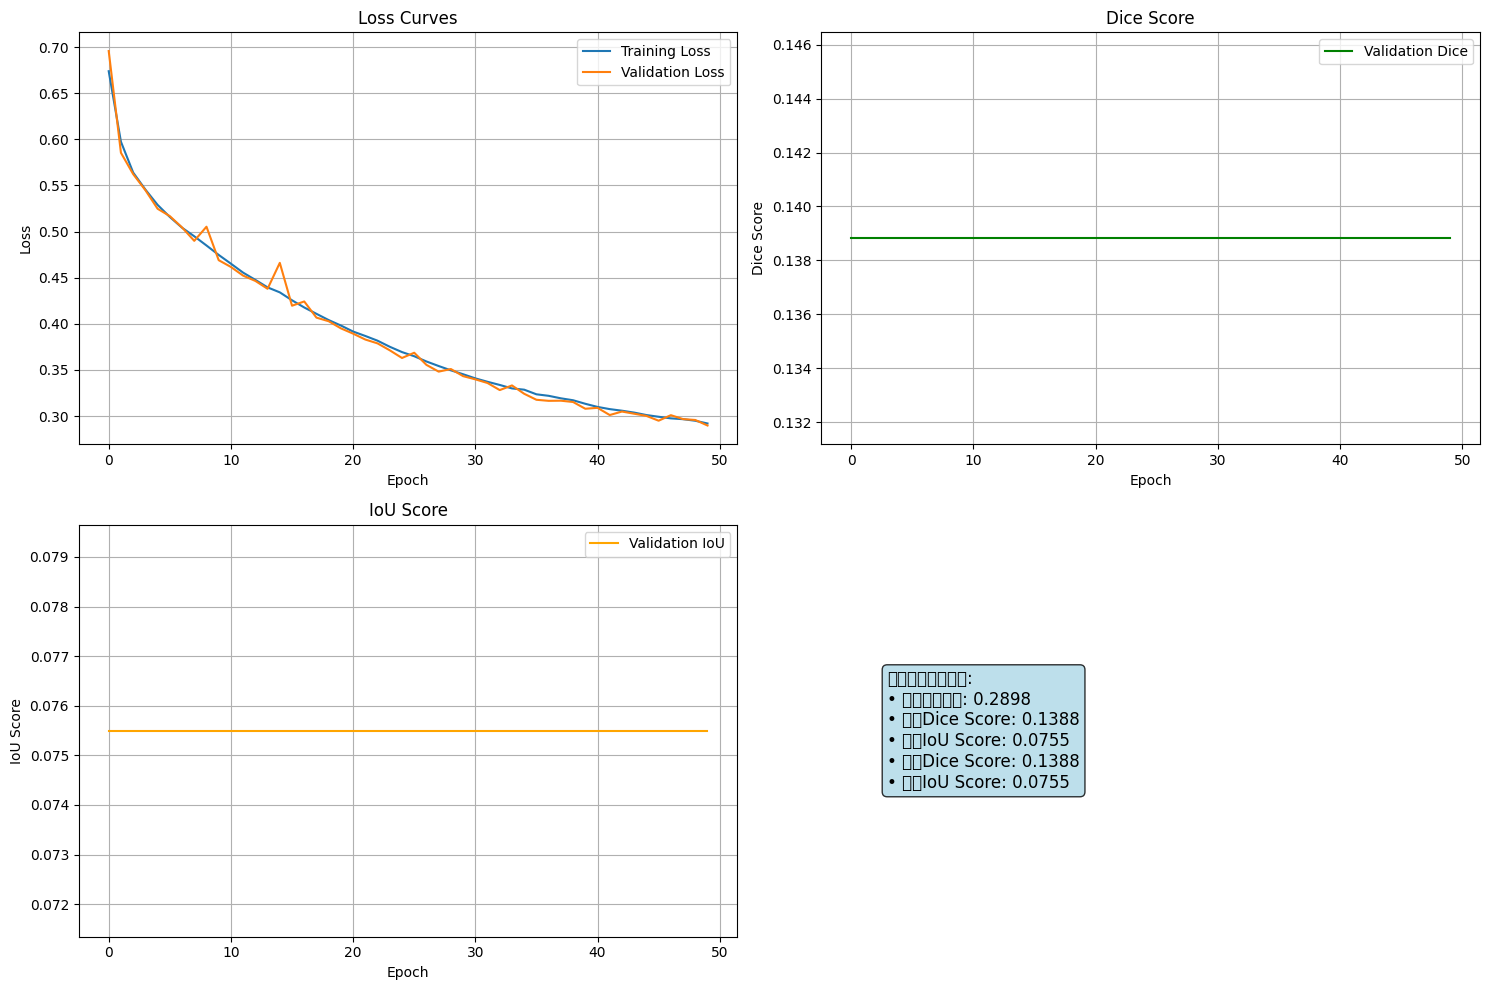

In [32]:
# 繪製訓練曲線
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 損失曲線
axes[0, 0].plot(train_losses, label='Training Loss')
axes[0, 0].plot(val_losses, label='Validation Loss')
axes[0, 0].set_title('Loss Curves')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Dice Score曲線
axes[0, 1].plot(val_dice_scores, label='Validation Dice', color='green')
axes[0, 1].set_title('Dice Score')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Dice Score')
axes[0, 1].legend()
axes[0, 1].grid(True)

# IoU Score曲線
axes[1, 0].plot(val_iou_scores, label='Validation IoU', color='orange')
axes[1, 0].set_title('IoU Score')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('IoU Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 最終指標摘要
final_metrics = f"""最終訓練結果摘要:
• 最佳驗證損失: {min(val_losses):.4f}
• 最佳Dice Score: {max(val_dice_scores):.4f}
• 最佳IoU Score: {max(val_iou_scores):.4f}
• 最終Dice Score: {val_dice_scores[-1]:.4f}
• 最終IoU Score: {val_iou_scores[-1]:.4f}"""

axes[1, 1].text(0.1, 0.5, final_metrics, transform=axes[1, 1].transAxes,
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

10. 測試結果展示

樣本 1 - Dice: 0.1036, IoU: 0.0546
樣本 6 - Dice: 0.1819, IoU: 0.1001
樣本 11 - Dice: 0.1813, IoU: 0.0997
樣本 16 - Dice: 0.1166, IoU: 0.0619
樣本 21 - Dice: 0.0905, IoU: 0.0474


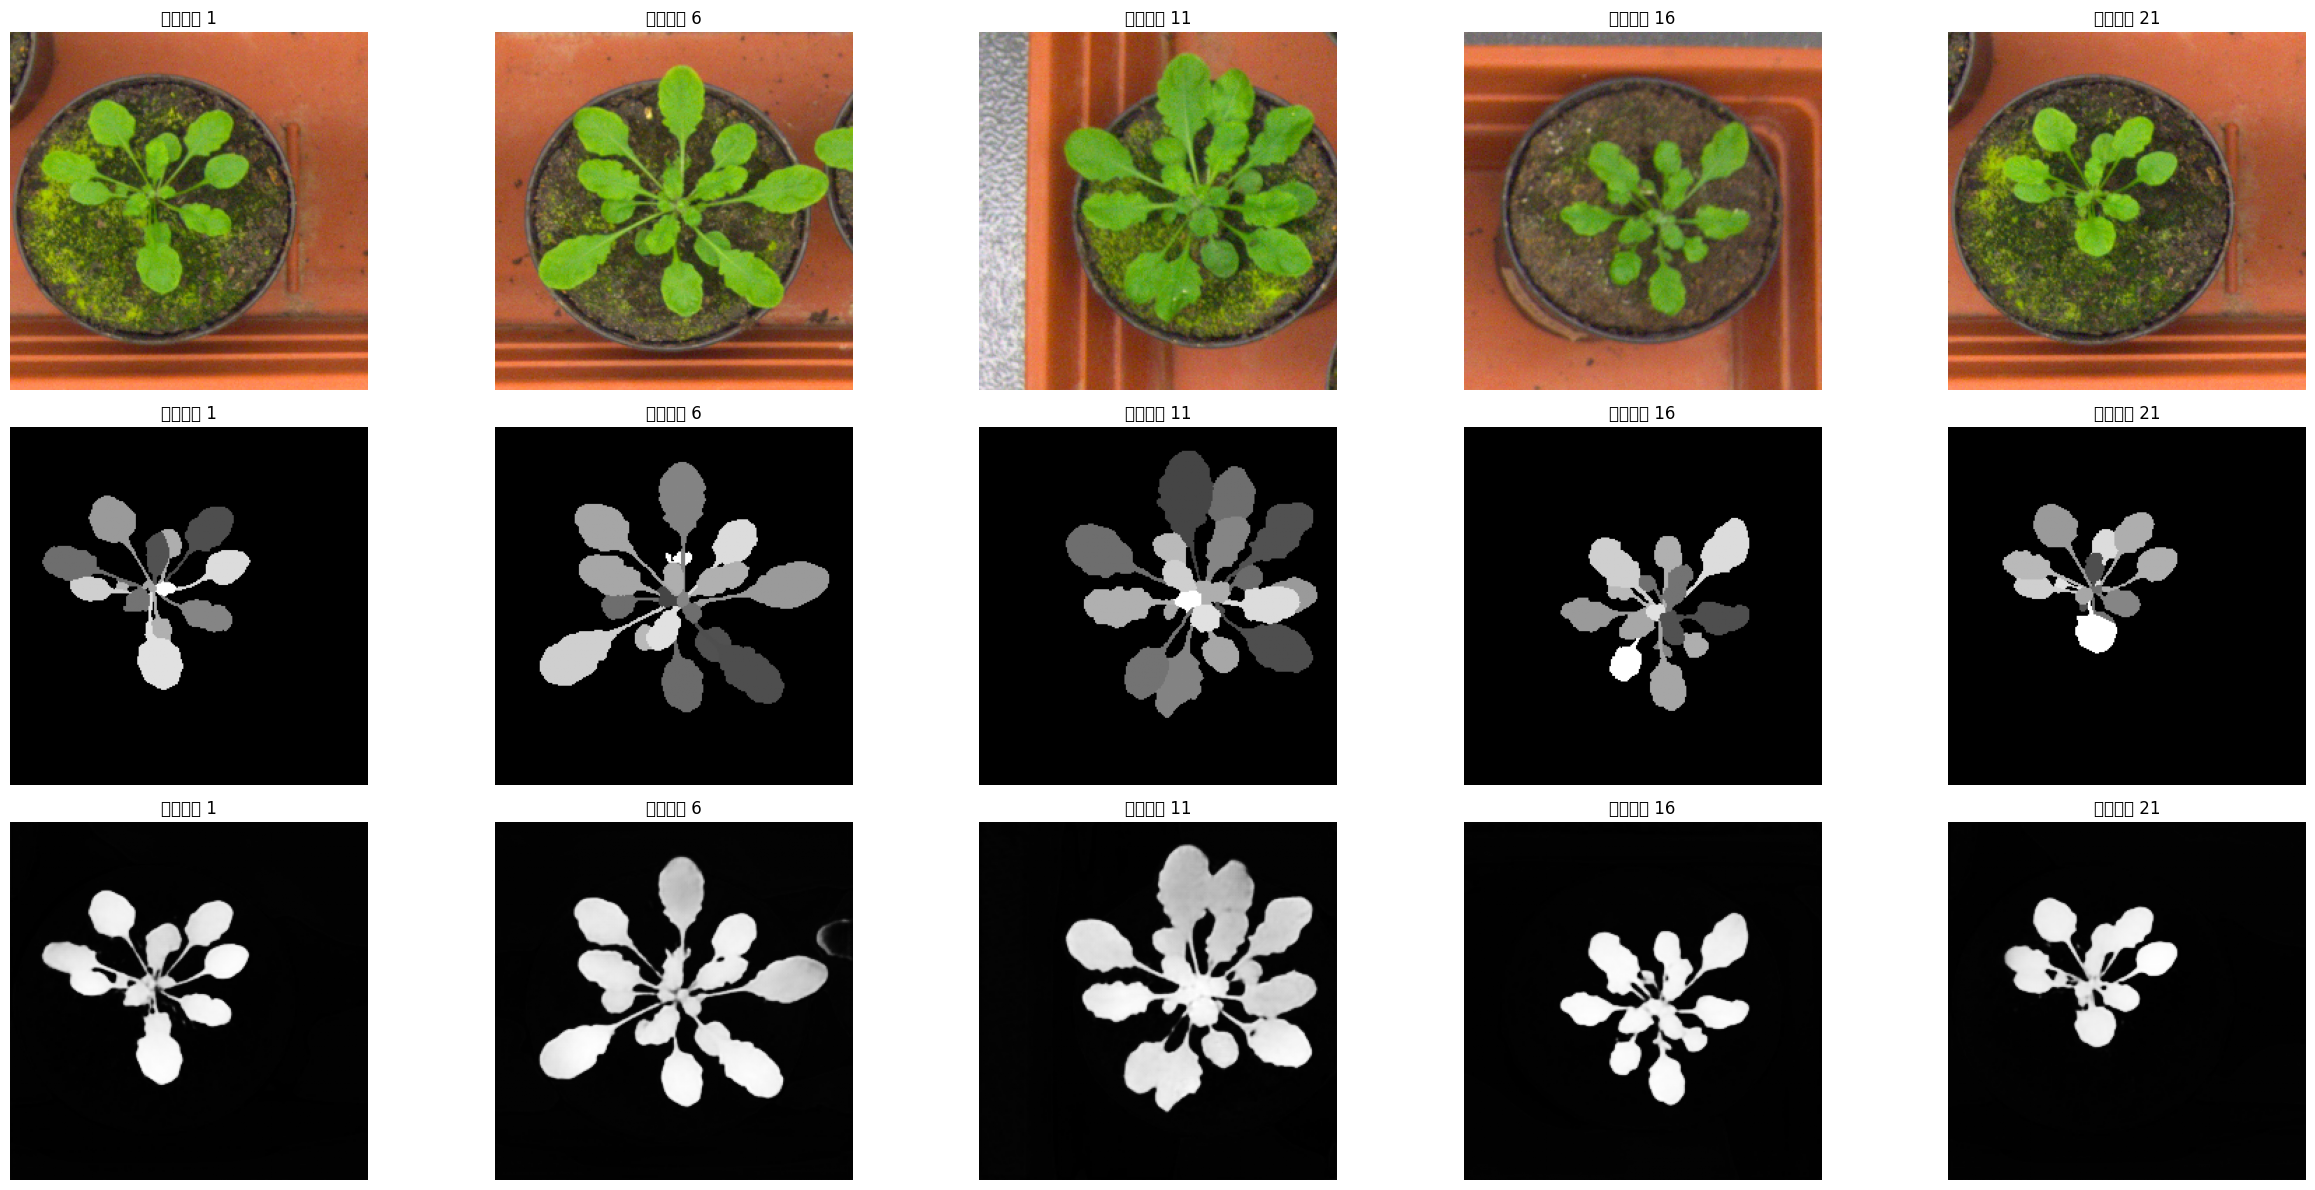

In [33]:
# 載入最佳模型
model.load_state_dict(torch.load('best_unet_model.pth'))
model.eval()

def predict_and_visualize(model, dataset, indices, device):
    fig, axes = plt.subplots(3, len(indices), figsize=(5*len(indices), 12))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # 獲取資料
            image, mask = dataset[idx]
            image_tensor = image.unsqueeze(0).to(device)

            # 預測
            pred = model(image_tensor)
            pred = pred.squeeze().cpu().numpy()

            # 反正規化影像以供顯示
            image_np = image.permute(1, 2, 0).cpu().numpy()
            image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)

            mask_np = mask.squeeze().cpu().numpy()

            # 顯示結果
            axes[0, i].imshow(image_np)
            axes[0, i].set_title(f'原始影像 {idx+1}')
            axes[0, i].axis('off')

            axes[1, i].imshow(mask_np, cmap='gray')
            axes[1, i].set_title(f'真實遮罩 {idx+1}')
            axes[1, i].axis('off')

            axes[2, i].imshow(pred, cmap='gray')
            axes[2, i].set_title(f'預測結果 {idx+1}')
            axes[2, i].axis('off')

            # 計算指標
            dice = dice_coefficient(torch.tensor(pred), torch.tensor(mask_np))
            iou = iou_score(torch.tensor(pred), torch.tensor(mask_np))

            print(f"樣本 {idx+1} - Dice: {dice:.4f}, IoU: {iou:.4f}")

    plt.tight_layout()
    plt.show()

# 展示驗證集中的預測結果
test_indices = [0, 5, 10, 15, 20]  # 選擇幾個樣本進行展示
predict_and_visualize(model, val_dataset, test_indices, device)